# Engaging with Multimodal Models: GPT-4V in AutoGen

In AutoGen, leveraging multimodal models can be done through two different methodologies:
1. **MultimodalAgent**: Supported by GPT-4V and other LMMs, this agent is endowed with visual cognitive abilities, allowing it to engage in interactions comparable to those of other ConversableAgents.
2. **VisionCapability**: For LLM-based agents lacking inherent visual comprehension, we introduce vision capabilities by converting images into descriptive captions.

This guide will delve into each approach, providing insights into their application and integration.

### Before everything starts, install AutoGen with the `lmm` option

Install `pyautogen`:
```bash
pip install "pyautogen[lmm]>=0.2.22"
```

For more information, please refer to the [installation guide](/docs/installation/).


In [1]:
import json
import os
import random
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.capabilities.vision_capability import VisionCapability
from autogen.agentchat.contrib.img_utils import AGImage, get_image_data, get_pil_image, pil_to_data_uri
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.code_utils import content_str

In [2]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)

The config_list_4v should be something like:

```python
[
    {
        'model': 'gpt-4-vision-preview', 
        'api_key': 'your-api-key'
    }
]
```

In [3]:
# NOTE!!! It is important to have the following parameters setup this way, otherwise the
# GPT-4V client might crash. Because GPT-4v does not not accept JSON objects or function calling.
# The max_image_size should be 10 for Azure OpenAI API, but could be more than 10 if using OpenAI.

gpt4v_llm_config = {
    "config_list": config_list_4v,
    "cache_seed": 42,
    "vision_model": True,
    "json_object": False,
    "tool_call": False,
    "max_num_image": 10,
}

In [4]:
image_agent = ConversableAgent(
    name="image-explainer",
    max_consecutive_auto_reply=10,
    llm_config=gpt4v_llm_config,
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    human_input_mode="NEVER",  # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0,
    code_execution_config={
        "use_docker": False
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)


# It can receive regular string message
user_proxy.initiate_chat(image_agent, message="hi")

User_proxy (to image-explainer):

hi

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

Hello! How can I assist you today?

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'hi', 'role': 'assistant'}, {'content': 'Hello! How can I assist you today?', 'role': 'user'}], summary='Hello! How can I assist you today?', cost=({'total_cost': 0.00046, 'gpt-4-1106-vision-preview': {'cost': 0.00046, 'prompt_tokens': 19, 'completion_tokens': 9, 'total_tokens': 28}}, {'total_cost': 0}), human_input=[])

<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F11303C4700>
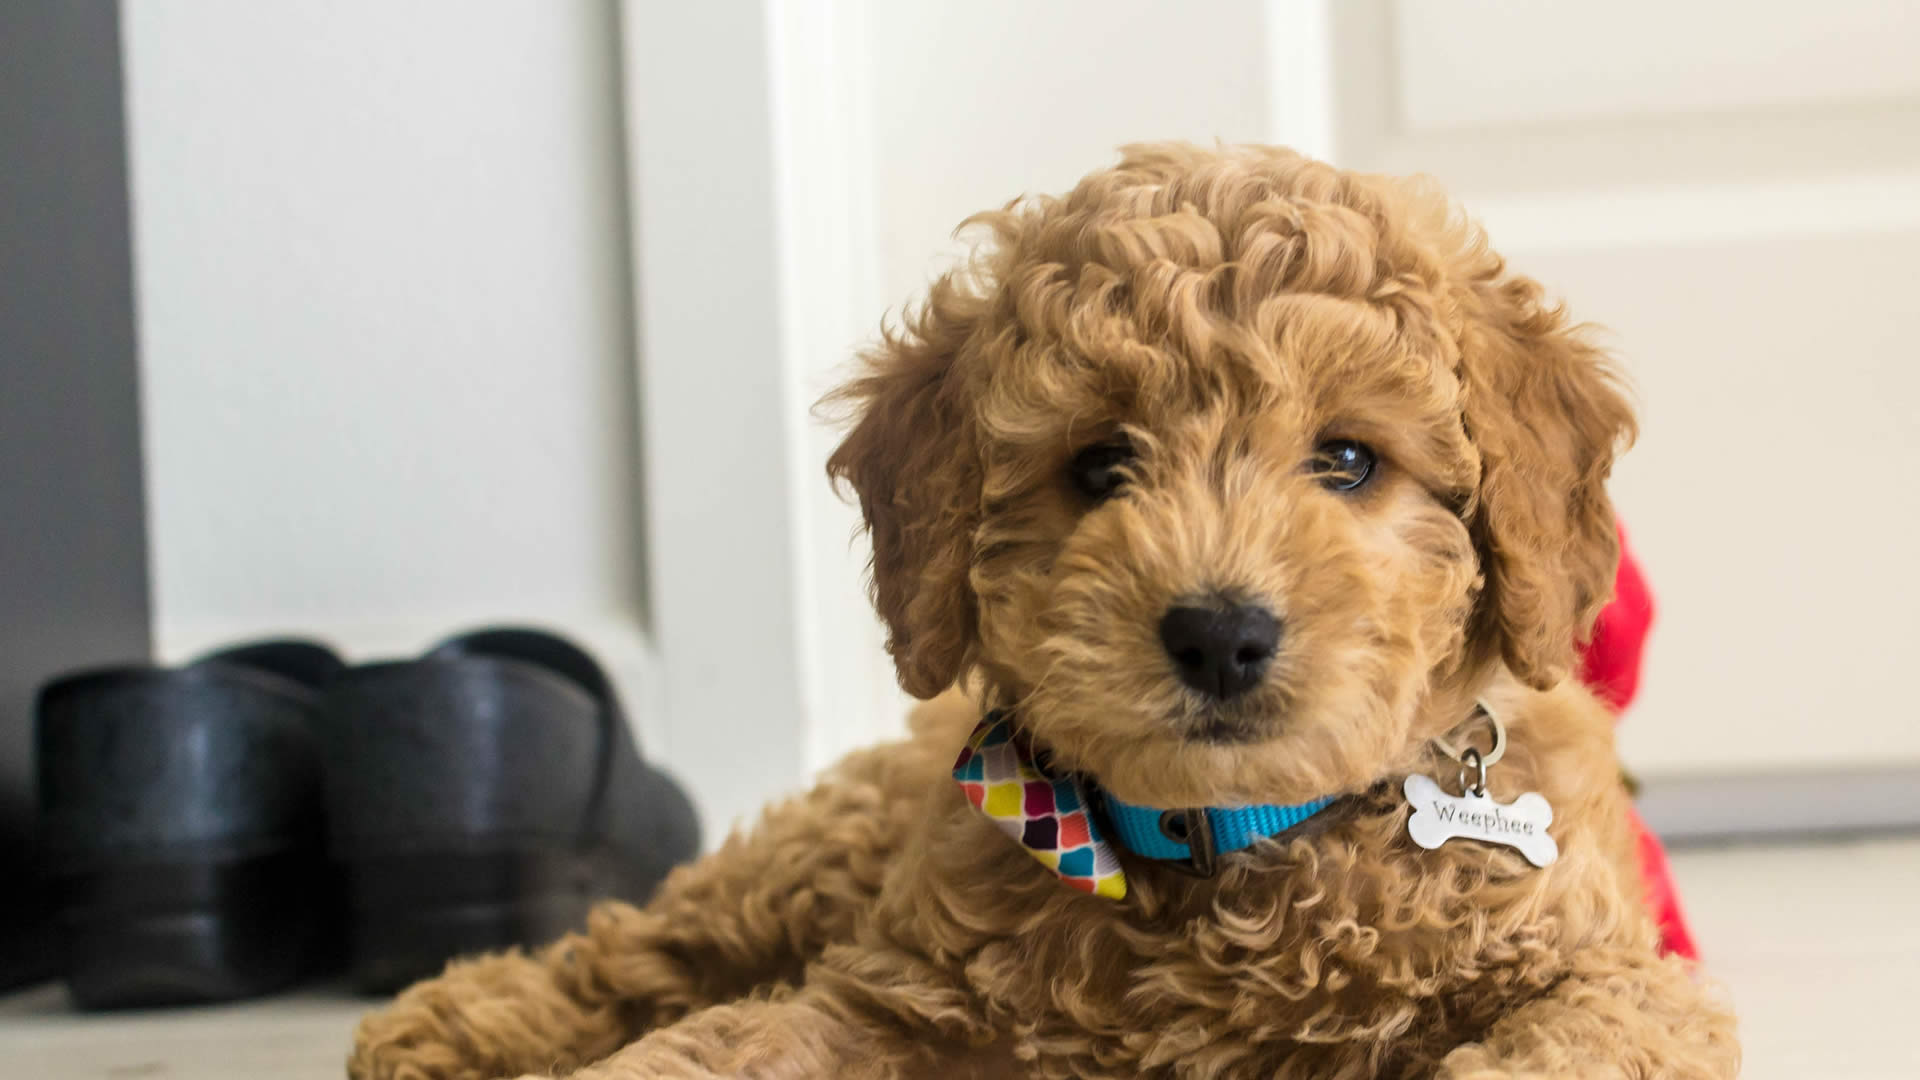

In [5]:
# Let's view this image
AGImage("https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0")

In [6]:
user_proxy.initiate_chat(
    image_agent,
    message=[
        "What's the breed of this dog?",
        AGImage("https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0"),
    ],
)

User_proxy (to image-explainer):

What's the breed of this dog? <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F10EE0CDDF0>

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The dog in the image appears to be a Goldendoodle, which is a cross-breed dog obtained by breeding a Golden Retriever with a Poodle. The curly coat and the overall appearance suggest this mix, but without a genetic test, it's not possible to be 100% certain of the breed or mix of breeds.

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': ["What's the breed of this dog?", <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F10EE0CDDF0>], 'role': 'assistant'}, {'content': "The dog in the image appears to be a Goldendoodle, which is a cross-breed dog obtained by breeding a Golden Retriever with a Poodle. The curly coat and the overall appearance suggest this mix, but without a genetic test, it's not possible to be 100% certain of the breed or mix of breeds.", 'role': 'user'}], summary="The dog in the image appears to be a Goldendoodle, which is a cross-breed dog obtained by breeding a Golden Retriever with a Poodle. The curly coat and the overall appearance suggest this mix, but without a genetic test, it's not possible to be 100% certain of the breed or mix of breeds.", cost=({'total_cost': 0.013810000000000001, 'gpt-4-1106-vision-preview': {'cost': 0.013810000000000001, 'prompt_tokens': 1150, 'completion_tokens': 77, 'total_tokens': 1227}}, {'total_cost': 0}), human_in

## Group Chat

In [7]:
agent1 = ConversableAgent(
    name="image-explainer-1",
    max_consecutive_auto_reply=10,
    llm_config=gpt4v_llm_config,
    system_message="Your image description is poetic and engaging.",
)
agent2 = ConversableAgent(
    name="image-explainer-2",
    max_consecutive_auto_reply=10,
    llm_config=gpt4v_llm_config,
    system_message="Your image description is factual and to the point.",
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="Desribe image for me.",
    human_input_mode="TERMINATE",
    max_consecutive_auto_reply=10,
)

# We set max_round to 5
groupchat = autogen.GroupChat(agents=[agent1, agent2, user_proxy], messages=[], max_round=5)
group_chat_manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt4v_llm_config)

user_proxy.initiate_chat(
    group_chat_manager,
    message=[
        "Write a poet for my image",
        AGImage("https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0"),
    ],
)

User_proxy (to chat_manager):

Write a poet for my image <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F10EE0F1DC0>

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer-1 (to chat_manager):

In a realm where pixels dance,
A tapestry woven in RGB trance,
On a digital loom so wide and vast,
A creation at 0x7F10EE0F1DC0 cast.

Beneath the watchful eye of code,
A world within a frame abode,
In a resolution grand and true,
A story told in every hue.

Here lies an art of modern age,
Where colors leap off the virtual stage,
Captured at the height of tech,
A moment paused, a fleeting speck.

The canvas, a screen of high decree,
Displays a vision for all to see,
A painter's dream in pixel form,
A place where digital muses swarm.

So gaze upon this work so bright,
A blending of data and purest light,
For within this image, we may find,
The height of human creative mind.

--------------------------------------------

ChatResult(chat_id=None, chat_history=[{'content': ['Write a poet for my image', <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F10EE0F1DC0>], 'role': 'assistant'}, {'content': "In a realm where pixels dance,\nA tapestry woven in RGB trance,\nOn a digital loom so wide and vast,\nA creation at 0x7F10EE0F1DC0 cast.\n\nBeneath the watchful eye of code,\nA world within a frame abode,\nIn a resolution grand and true,\nA story told in every hue.\n\nHere lies an art of modern age,\nWhere colors leap off the virtual stage,\nCaptured at the height of tech,\nA moment paused, a fleeting speck.\n\nThe canvas, a screen of high decree,\nDisplays a vision for all to see,\nA painter's dream in pixel form,\nA place where digital muses swarm.\n\nSo gaze upon this work so bright,\nA blending of data and purest light,\nFor within this image, we may find,\nThe height of human creative mind.", 'name': 'image-explainer-1', 'role': 'user'}, {'content': "I'm sorry, as an AI language model, I do not have 